In [1]:
import numpy as np
import scipy.io as spio
import h5py
import cv2
from os.path import join as pjoin
from os import listdir
from re import compile as recompile
from collections import Counter

In [2]:
%matplotlib inline

# Font which got unicode math stuff.
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'

# Much more readable plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
import lbtoolbox.plotting as lbplt
import lbtoolbox.util as lbu

# IDIAP Subset

Not interesting, we always work with the full data.

# IDIAP Full

Some utilities to get sensible data structures out of MATLAB-generated HDF5 files...

In [4]:
def extract_array(mat, ref, dtype=np.float32):
    N = len(ref)
    arr = np.empty(N, dtype=dtype) # mat[ref[0,0]].dtype
    for i in range(N):
        arr[i] = mat[ref[i,0]][0,0]
    return arr

In [5]:
def read_tosato(folder):
    mat_full = h5py.File(pjoin(folder, 'or_label_full.mat'))

    def loadall(traintest):
        container = mat_full['or_label_' + traintest]
        Pte = extract_array(mat_full, container['pan'])
        Tte = extract_array(mat_full, container['tilt'])
        Rte = extract_array(mat_full, container['roll'])
        return Pte, Tte, Rte

    return loadall('train'), loadall('test')

tosato_ihdp = read_tosato('data/IHDPHeadPose')
(Ptr, Ttr, Rtr), (Pte, Tte, Rte) = tosato_ihdp

In [6]:
lbu.printnow('{} files in Training.', len(Ptr))
lbu.printnow('{} files in Testing.', len(Pte))

42304 files in Training.
23991 files in Testing.


## Have a look at the label frequencies

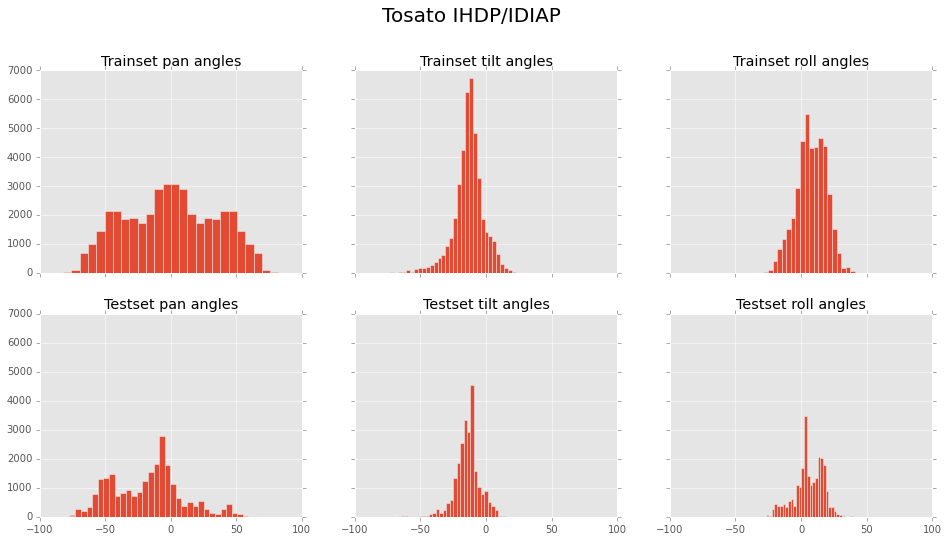

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(16,8), sharex=True, sharey=True)
axes[0,0].hist(np.rad2deg(Ptr), bins=32)
axes[1,0].hist(np.rad2deg(Pte), bins=32)
axes[0,1].hist(np.rad2deg(Ttr), bins=32)
axes[1,1].hist(np.rad2deg(Tte), bins=32)
axes[0,2].hist(np.rad2deg(Rtr), bins=32)
axes[1,2].hist(np.rad2deg(Rte), bins=32)
axes[0,0].set_title('Trainset pan angles')
axes[1,0].set_title('Testset pan angles')
axes[0,1].set_title('Trainset tilt angles')
axes[1,1].set_title('Testset tilt angles')
axes[0,2].set_title('Trainset roll angles')
axes[1,2].set_title('Testset roll angles')
axes[0,0].set_xlim(-100, 100)
fig.suptitle('Tosato IHDP/IDIAP', fontsize=20, y=1.01)

A zoom-in on the training pan range for my talk's slides.

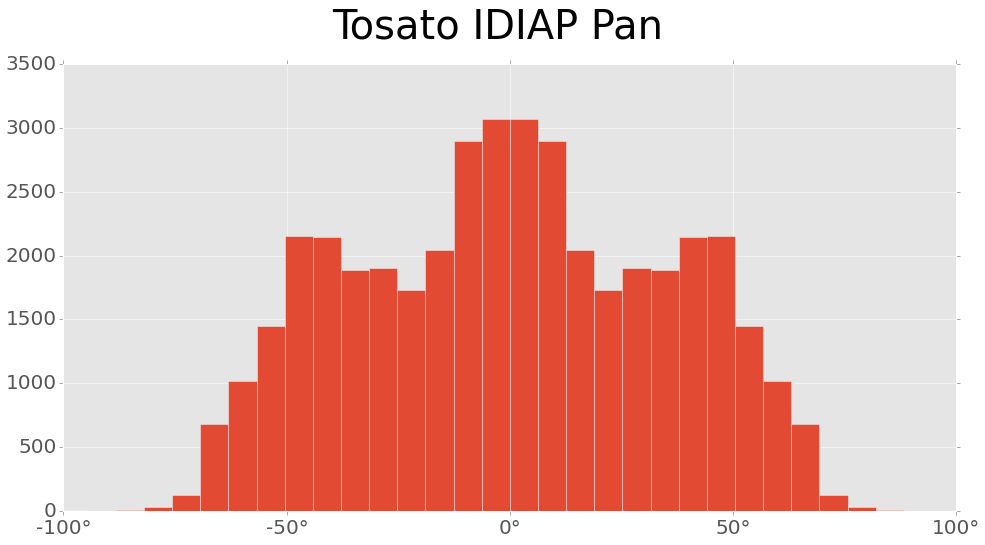

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
ax.hist(np.rad2deg(Ptr), bins=32)
ax.set_xlim(-100,100)
ax.axes.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:n}°'.format(x)))
fig.suptitle('Tosato IDIAP Pan', fontsize=20, y=1.0)
lbplt.zoomtext(fig)
lbplt.savefig(fig, 'idiap_pan_hist', transparent=False)

Clearly, either they have been mirrored already, or subsampled in order to have a symmetric distribution. Thus, I won't apply any flipping augmentation here to be on the safe side.

## A closer look at the covered angle ranges

In [9]:
def minmax(x): return np.min(x), np.max(x)
rangefmt = '[{:7.2f}°,{:6.2f}°]'

lbu.printnow('Training: Pan range: '+rangefmt+', Tilt range: '+rangefmt+', Roll range: '+rangefmt,
    *minmax(np.rad2deg(Ptr)) + minmax(np.rad2deg(Ttr)) + minmax(np.rad2deg(Rtr))
)
lbu.printnow('Testing:  Pan range: '+rangefmt+', Tilt range: '+rangefmt+', Roll range: '+rangefmt,
    *minmax(np.rad2deg(Pte)) + minmax(np.rad2deg(Tte)) + minmax(np.rad2deg(Rte))
)

Training: Pan range: [-100.87°,100.87°], Tilt range: [ -72.60°, 22.82°], Roll range: [ -46.03°, 65.34°]
Testing:  Pan range: [ -76.86°, 59.15°], Tilt range: [ -69.71°, 14.59°], Roll range: [ -26.37°, 39.32°]


In [10]:
def inrange(y, lim, name):
    lbu.printnow('{:.2%} of {} in [-{lim:n}°, {lim:n}°]', np.mean((-lim < y) & (y < lim)), name, lim=round(np.rad2deg(lim)))
def inrange2(y, lim1, lim2, name):
    lbu.printnow('{:.2%} of {} in [{:n}°, {:n}°]', np.mean((lim1 < y) & (y < lim2)), name, round(np.rad2deg(lim1)), round(np.rad2deg(lim2)))

In [11]:
inrange(Ptr, np.deg2rad(60), 'pan')

93.92% of pan in [-60°, 60°]


In [12]:
inrange(Ptr, np.deg2rad(56), 'pan')

90.46% of pan in [-56°, 56°]


In [13]:
inrange2(Ttr, np.deg2rad(-60), np.deg2rad(15), 'tilt')

99.03% of tilt in [-60°, 15°]


In [14]:
inrange2(Ttr, np.deg2rad(-30), np.deg2rad(10), 'tilt')

90.67% of tilt in [-30°, 10°]


In [15]:
inrange2(Rtr, np.deg2rad(-30), np.deg2rad(30), 'roll')

98.59% of roll in [-30°, 30°]


In [16]:
inrange2(Rtr, -0.2, 0.5, 'roll')

92.04% of roll in [-11°, 29°]


# Shopping Full

In [17]:
def extract_vector(arr, col, dtype=np.float32):
    N = len(arr)
    vec = np.empty(N, dtype=dtype)  # NOTE: DO NOT TRUST AUTO DTYPE EXTRACTION!
    for i in range(N):
        vec[i] = arr[i][col][0,0]
    return vec

def read_tosato_shopping(folder):
    mat = spio.loadmat(pjoin(folder, 'or_label.mat'))
    
    def loadall(traintest):
        gaze = extract_vector(mat['or_label_' + traintest][0], 0)
        xc = extract_vector(mat['or_label_' + traintest][0], 1)
        yc = extract_vector(mat['or_label_' + traintest][0], 2)
        size = extract_vector(mat['or_label_' + traintest][0], 3)
        return gaze, xc, yc, size

    return loadall('train'), loadall('test')

tosato_shopping = read_tosato_shopping('data/CAVIARShoppingCenterFull')
(ystr, xc_tr, yc_tr, size_tr), (yste, xc_te, yc_te, size_te) = tosato_shopping

In [18]:
lbu.printnow('{} files in Training.', len(ystr))
lbu.printnow('{} files in Testing.', len(yste))

10660 files in Training.
10665 files in Testing.


## Have a look at the label frequencies

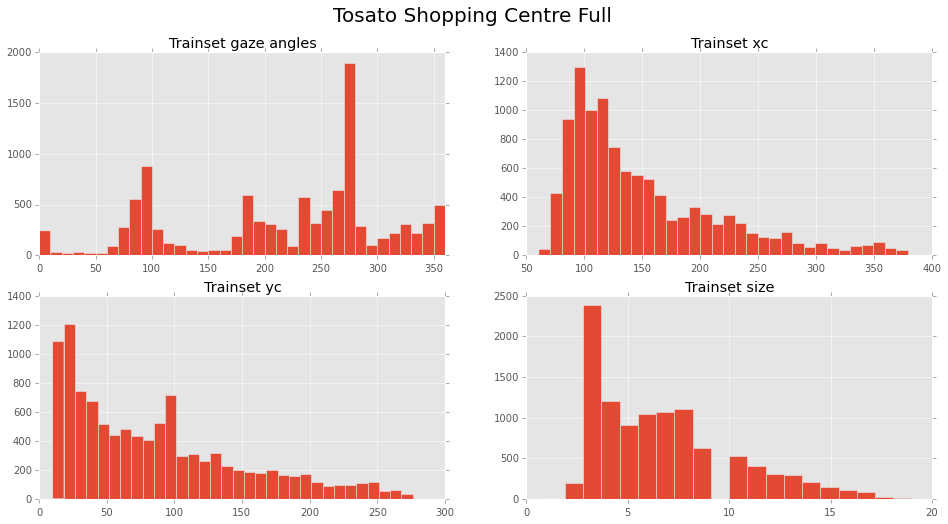

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16,8))
axes[0,0].hist(ystr, bins=36)
axes[0,1].hist(xc_tr, bins=32)
axes[1,0].hist(yc_tr, bins=32)
axes[1,1].hist(size_tr, bins=20)
axes[0,0].set_title('Trainset gaze angles')
axes[0,1].set_title('Trainset xc')
axes[1,0].set_title('Trainset yc')
axes[1,1].set_title('Trainset size')
axes[0,0].set_xlim(0, 360)
fig.suptitle('Tosato Shopping Centre Full', fontsize=20)

A zoom-in on the training pan range for my talk's slides.

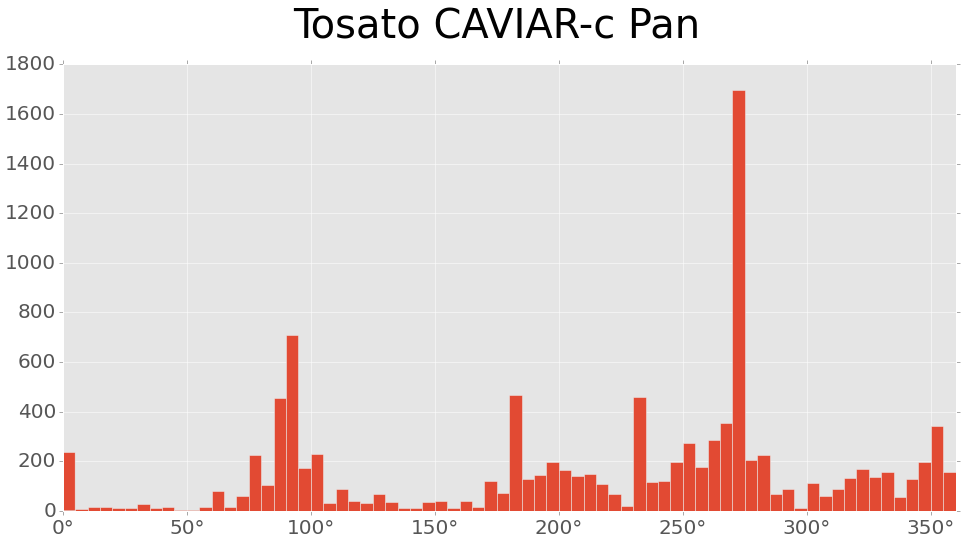

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
ax.hist(ystr, bins=36*2)
ax.set_xlim(0,360)
ax.axes.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:n}°'.format(x)))
fig.suptitle('Tosato CAVIAR-c Pan', fontsize=20, y=1.0)
lbplt.zoomtext(fig)
lbplt.savefig(fig, 'caviarc_pan_hist', transparent=False)

In [21]:
Counter(ystr).most_common(10)

[(270.0, 989),
 (272.0, 453),
 (90.0, 432),
 (180.0, 280),
 (234.0, 279),
 (88.0, 266),
 (350.0, 241),
 (274.0, 237),
 (268.0, 219),
 (86.0, 189)]

For the sentence in the paper about why this dataset isn't what I'm looking for.

In [22]:
def within_4p(y, rng):
    print('{:.2%} of data lies within ±{} of the four canonical orientations.'.format(
        np.mean((( 90-rng <= y) & (y <=  90+rng))
              | ((180-rng <= y) & (y <= 180+rng))
              | ((270-rng <= y) & (y <= 270+rng))
              | ((360-rng <= y) | (y <=   0+rng))),
        rng
    ))

In [23]:
within_4p(ystr, 4)

38.83% of data lies within ±4 of the four canonical orientations.


Also, look at how ridiculously small the original images are on average:

In [24]:
np.mean(size_tr)

6.6884613

# Shopping Full Occl

In [25]:
tosato_shopping_occl = read_tosato_shopping('data/CAVIARShoppingCenterFullOccl')
(ysotr, xc_so_tr, yc_so_tr, size_so_tr), (ysote, xc_so_te, yc_so_te, size_so_te) = tosato_shopping_occl

In [26]:
lbu.printnow('{} files in Training.', len(ysotr))
lbu.printnow('{} files in Testing.', len(ysote))

10802 files in Training.
10889 files in Testing.


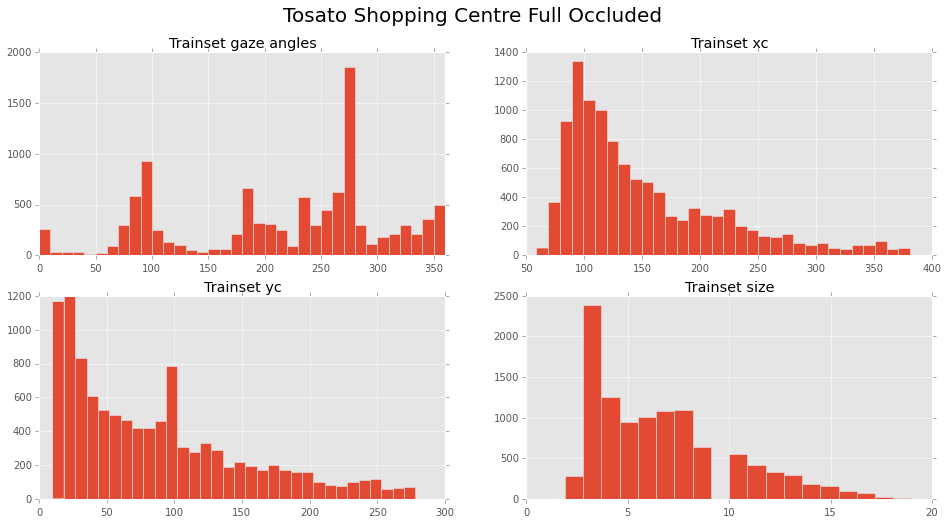

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16,8))
axes[0,0].hist(ysotr, bins=36)
axes[0,1].hist(xc_so_tr, bins=32)
axes[1,0].hist(yc_so_tr, bins=32)
axes[1,1].hist(size_so_tr, bins=20)
axes[0,0].set_title('Trainset gaze angles')
axes[0,1].set_title('Trainset xc')
axes[1,0].set_title('Trainset yc')
axes[1,1].set_title('Trainset size')
axes[0,0].set_xlim(0, 360)
fig.suptitle('Tosato Shopping Centre Full Occluded', fontsize=20)

Looks very similarly useless, so no need to investigate further.

# TownCentre Head Images (Benfold)

In [28]:
def load_towncentre(where):
    panre = recompile('pan = ([+-]?\d+\.\d+)\n')
    valre = recompile('valid = ([01])\n')
    angles = []
    images = []
    names = []
    for father in listdir(where):
      try:
        for son in listdir(pjoin(where, father)):
            if not son.endswith('.txt'):
                continue

            lpan, lval = open(pjoin(where, father, son)).readlines()
            if int(valre.match(lval).group(1)) == 0:
                continue

            angles.append(float(panre.match(lpan).group(1)))
            # Now search for the corresponding filename, unfortunately, it has more numbers encoded...
            fnames = [f for f in listdir(pjoin(where, father)) if f.startswith(son.split('.')[0]) and not f.endswith('.txt')]
            assert len(fnames) == 1, "lolwut"
            names.append(fnames[0])
            images.append(cv2.imread(pjoin(where, father, fnames[0]), flags=cv2.IMREAD_COLOR))
      except NotADirectoryError:
        pass

    return images, angles, names

bbtc_img, bbtc_a, bbtc_n = load_towncentre('data/TownCentreHeadImages')
bbtc_a_n = [(a + 360*2) % 360 for a in bbtc_a]

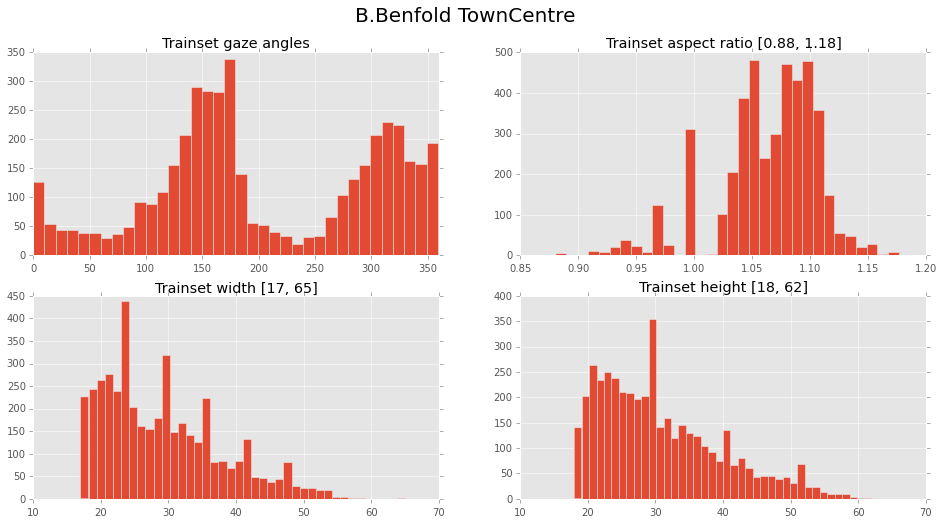

In [29]:
ws = [i.shape[1] for i in bbtc_img]
hs = [i.shape[0] for i in bbtc_img]
ar = [h/w for w,h in zip(ws, hs)]
fig, axes = plt.subplots(2, 2, figsize=(16,8))
axes[0,0].hist(bbtc_a_n, bins=36)
axes[0,1].hist(ar, bins=32)
axes[1,0].hist(ws, bins=40)
axes[1,1].hist(hs, bins=40)
axes[0,0].set_title('Trainset gaze angles')
axes[0,1].set_title('Trainset aspect ratio [{:.2f}, {:.2f}]'.format(min(ar), max(ar)))
axes[1,0].set_title('Trainset width [{}, {}]'.format(min(ws), max(ws)))
axes[1,1].set_title('Trainset height [{}, {}]'.format(min(hs), max(hs)))
axes[0,0].set_xlim(0, 360)
fig.suptitle('B.Benfold TownCentre', fontsize=20)

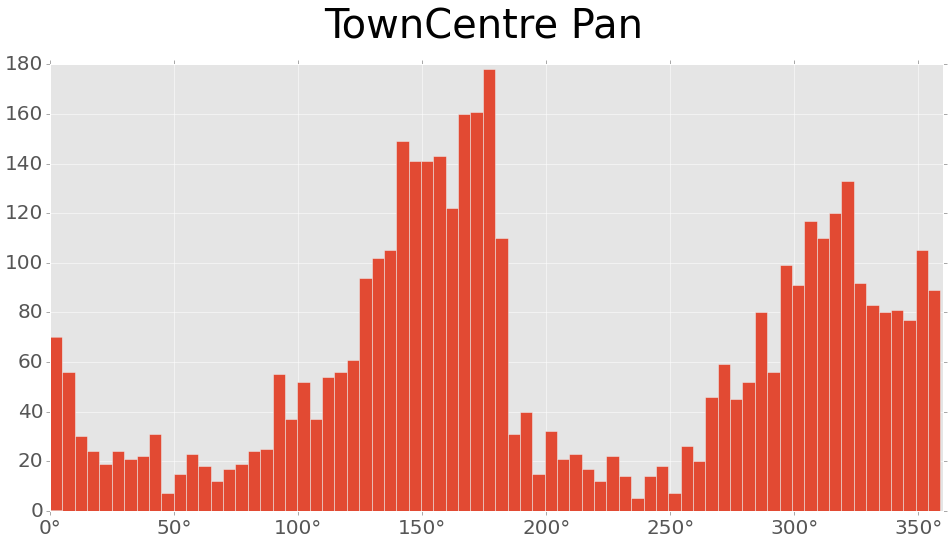

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
ax.hist(bbtc_a_n, bins=36*2)
ax.set_xlim(0,360)
ax.axes.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:n}°'.format(x)))
fig.suptitle('TownCentre Pan', fontsize=20, y=1.0)
lbplt.zoomtext(fig)
lbplt.savefig(fig, 'towncentre_pan_hist', transparent=False)